In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import vstack, issparse
import importlib
import functions

importlib.reload(functions)

pd.set_option('display.max_columns', None)

In [16]:
df = pd.read_csv('data/dataset_workout.csv')
df.head(3)

,Gender,Weight (kg),Height (m),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days),Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,E,I,S,D,R
0,Male,65.27,1.62,1080.90,Strength,1.50,4,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.570217,0.526466,0.250000,0.333333,0.637310
1,Female,56.41,1.55,1809.91,HIIT,1.90,4,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.740993,0.256055,0.225000,0.575163,0.862514
2,Female,58.98,1.67,802.26,Cardio,1.88,3,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.549660,0.289199,0.416667,0.274510,0.685580


In [17]:
user = pd.read_csv('data/new_user.csv')
user_full = user.copy()
user

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,Goal,WeightChange (kg),GoalDays,cluster_id,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout
0,22,Female,56.0,1.7,19.377163,1,2,2,Low-Carb,Loss,5.0,31,1,1351.5,1.55,2094.825,38500.0,19250.0,19250.0,1473.857258,8.857143,2173.387097


### Target calculation depending on goal from user

In [18]:
goal = user['Goal'].iloc[0]

if goal == 'Loss':
    df['target'] = 0.45*df['E'] + 0.25*df['I'] + 0.10*df['D'] + 0.05*df['S'] + 0.15*df['R']
elif goal == 'Maintain':
    df['target'] = 0.25*df['E'] + 0.20*df['I'] + 0.15*df['D'] + 0.20*df['S'] + 0.20*df['R']
elif goal == 'Gain':
    df['target'] = 0.05*df['E'] + 0.15*df['I'] + 0.10*df['D'] + 0.50*df['S'] + 0.20*df['R']
else:
    raise ValueError("Goal must be one of: 'Loss', 'Maintain', 'Gain'")

In [19]:
df.head(3)

,Gender,Weight (kg),Height (m),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days),Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,E,I,S,D,R,target
0,Male,65.27,1.62,1080.90,Strength,1.50,4,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.570217,0.526466,0.250000,0.333333,0.637310,0.529644
1,Female,56.41,1.55,1809.91,HIIT,1.90,4,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.740993,0.256055,0.225000,0.575163,0.862514,0.595604
2,Female,58.98,1.67,802.26,Cardio,1.88,3,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.549660,0.289199,0.416667,0.274510,0.685580,0.470768


### Training dataset preparation

In [20]:
# Drop target construction components
df = df.drop(columns=['E', 'I', 'D', 'S', 'R'])
df.head(3)

,Gender,Weight (kg),Height (m),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days),Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,target
0,Male,65.27,1.62,1080.90,Strength,1.50,4,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.529644
1,Female,56.41,1.55,1809.91,HIIT,1.90,4,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.595604
2,Female,58.98,1.67,802.26,Cardio,1.88,3,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.470768


In [21]:
numerical_features = [
    'Weight (kg)', 'Height (m)',
    'Workout_Frequency (days)', 'Daily meals frequency', 'rating'
]
categorical_features = [
    'Gender', 'Workout_Type', 'diet_type', 'Name of Exercise', 'Benefit',
    'Target Muscle Group', 'Equipment Needed', 'Body Part',
    'Type of Muscle', 'Workout', 'cluster_id'
]

In [22]:
selected_features = numerical_features + categorical_features + ['target']
 
# -------------------------------
# create df_selected
# calories_burned is NOT included here
# -------------------------------
df_selected = df[selected_features].copy()
df_selected.head(3)

,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,rating,Gender,Workout_Type,diet_type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,target
0,65.27,1.62,4,3,1.31,Male,Strength,Vegan,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.529644
1,56.41,1.55,4,3,1.92,Female,HIIT,Vegetarian,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.595604
2,58.98,1.67,3,2,4.70,Female,Cardio,Paleo,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.470768


In [23]:
# =========================
# 3) Split X/y (Train / Val / Test)
# =========================
X = df_selected.drop(columns=["target"])
y = df_selected["target"]

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [24]:
# =========================
# 4) One-hot encoding (fit on train only, transform val/test)
# =========================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc   = preprocess.transform(X_val)
X_test_enc  = preprocess.transform(X_test)

# Helper function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


### Baseline model: Linear Regression

In [25]:
# ============================================================
# SECTION 1: BASELINE MODEL (Linear Regression baseline)
# ============================================================
baseline_lr = LinearRegression()
baseline_lr.fit(X_train_enc, y_train)

val_pred_lr = baseline_lr.predict(X_val_enc)
val_rmse_lr = rmse(y_val, val_pred_lr)

print(f"[Baseline] Validation RMSE (Linear Regression): {val_rmse_lr:.6f}")

[Baseline] Validation RMSE (Linear Regression): 0.074544


### Main model: XGBoost

In [26]:
# ============================================================
# SECTION 2: MODEL WITH MANUAL HYPERPARAMETERS (manual n_estimators selection)
# ============================================================
n_estimators_list = [50, 100, 200, 300, 500]
manual_results = []

for n in n_estimators_list:
    xgb_manual_candidate = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    xgb_manual_candidate.fit(X_train_enc, y_train)
    val_pred = xgb_manual_candidate.predict(X_val_enc)
    manual_results.append((n, rmse(y_val, val_pred)))

best_n_estimators, best_val_rmse_manual = min(manual_results, key=lambda x: x[1])

print(f"[Manual HP] Best n_estimators: {best_n_estimators}")
print(f"[Manual HP] Validation RMSE: {best_val_rmse_manual:.6f}")


[Manual HP] Best n_estimators: 500
[Manual HP] Validation RMSE: 0.049358


In [27]:
# Train the "manual HP model" on train only (classical)
xgb_manual_best = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_manual_best.fit(X_train_enc, y_train)

test_pred_manual = xgb_manual_best.predict(X_test_enc)
test_rmse_manual = rmse(y_test, test_pred_manual)
print(f"[Manual HP] Test RMSE: {test_rmse_manual:.6f}")


[Manual HP] Test RMSE: 0.050557


### Hyperparameter tuning

In [28]:
# ============================================================
# SECTION 3: MODEL WITH TUNED HYPERPARAMETERS (RandomizedSearchCV on TRAIN only)
# ============================================================
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [100, 200, 300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 5, 10],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# IMPORTANT: Fit on TRAIN only 
search.fit(X_train_enc, y_train)

best_params = search.best_params_
best_cv_rmse = np.sqrt(-search.best_score_)

print("[Tuned HP] Best CV params:", best_params)
print(f"[Tuned HP] Best CV RMSE: {best_cv_rmse:.6f}")

# evaluate tuned model on VALIDATION as a holdout check
xgb_tuned_train_only = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_tuned_train_only.fit(X_train_enc, y_train)

val_pred_tuned = xgb_tuned_train_only.predict(X_val_enc)
val_rmse_tuned = rmse(y_val, val_pred_tuned)
print(f"[Tuned HP] Validation RMSE (holdout check): {val_rmse_tuned:.6f}")



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Tuned HP] Best CV params: {'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.0001, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}
[Tuned HP] Best CV RMSE: 0.036428
[Tuned HP] Validation RMSE (holdout check): 0.033019


In [29]:
# ============================================================
# SECTION 4: FINAL MODEL (best tuned hyperparams substituted)
# Classical step: train on TRAIN+VAL, then test once
# ============================================================
# Combine train + val encoded matrices
if issparse(X_train_enc) or issparse(X_val_enc):
    X_trainval_enc = vstack([X_train_enc, X_val_enc])
else:
    X_trainval_enc = np.vstack([X_train_enc, X_val_enc])

y_trainval = np.concatenate([y_train.to_numpy(), y_val.to_numpy()])

final_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_trainval_enc, y_trainval)

test_pred_final = final_model.predict(X_test_enc)
test_rmse_final = rmse(y_test, test_pred_final)
print(f"[FINAL] Test RMSE (trained on train+val): {test_rmse_final:.6f}")

[FINAL] Test RMSE (trained on train+val): 0.032145


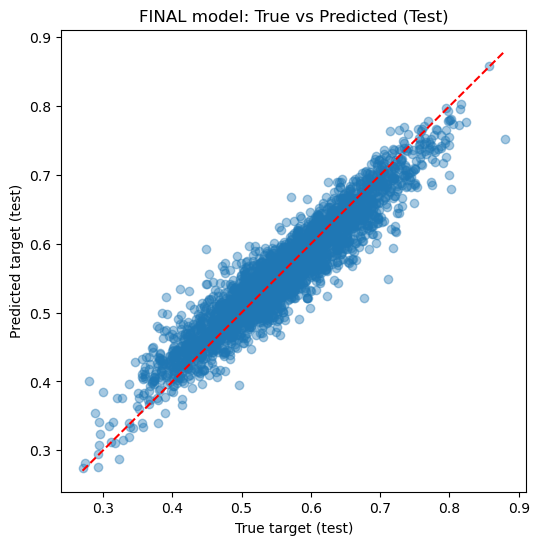

In [30]:
# ============================================================
# SECTION 5: VISUALIZATIONS (with FINAL model)
# Use TEST for unbiased visual diagnostics
# ============================================================
# True vs Predicted (TEST)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred_final, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True target (test)")
plt.ylabel("Predicted target (test)")
plt.title("FINAL model: True vs Predicted (Test)")
plt.show()


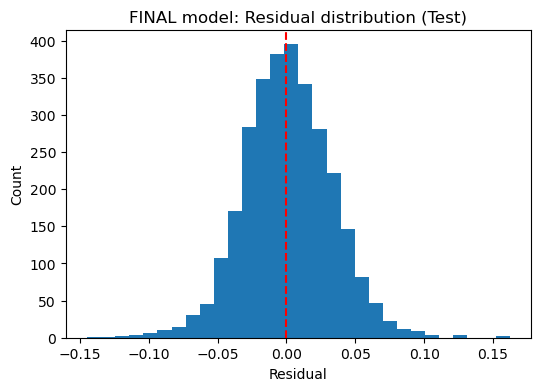

In [31]:
# Residuals (TEST)
test_residuals = y_test - test_pred_final

plt.figure(figsize=(6, 4))
plt.hist(test_residuals, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("FINAL model: Residual distribution (Test)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


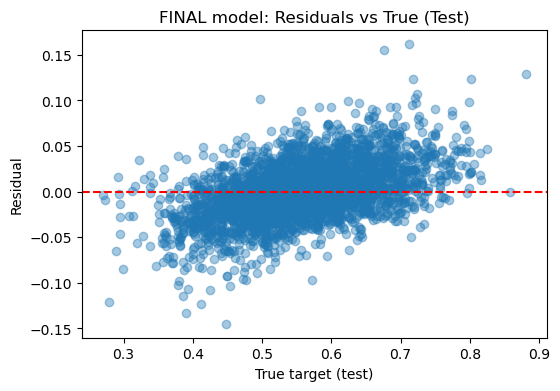

In [32]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, test_residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True target (test)")
plt.ylabel("Residual")
plt.title("FINAL model: Residuals vs True (Test)")
plt.show()

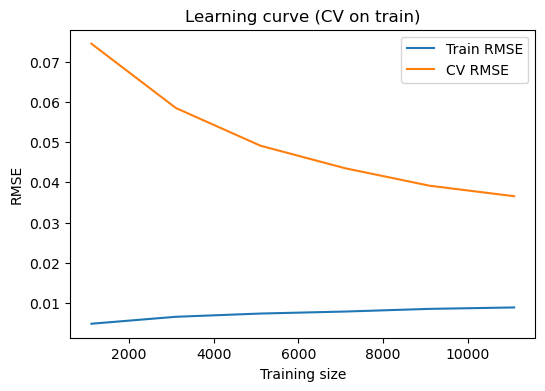

In [33]:
# Learning curve (on TRAIN only; CV inside)
est_for_curve = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

train_sizes, train_scores, val_scores = learning_curve(
    est_for_curve,
    X_train_enc,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

train_rmse_curve = np.sqrt(-train_scores.mean(axis=1))
val_rmse_curve   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_rmse_curve, label="Train RMSE")
plt.plot(train_sizes, val_rmse_curve, label="CV RMSE")
plt.xlabel("Training size")
plt.ylabel("RMSE")
plt.title("Learning curve (CV on train)")
plt.legend()
plt.show()

#### Save the model and encoder

In [34]:
joblib.dump(preprocess, "encoders/workout_encoder.pkl")
joblib.dump(final_model, "models/workout_model.pkl")

['models/workout_model.pkl']

### Create testing data

In [35]:
user_full = user.copy()
user = user.drop(
                    columns=['Age', 'Experience_Level', 'Goal', 'WeightChange (kg)', 'GoalDays', 'BMR', 'PAL', 'TDEE', 'CalorieChange', 'CaloriesToBurnTraining', 
                        'CaloriesReducedFromFood', 'CaloriesPerDay',  'TotalWorkouts', 'CaloriesPerWorkout', "BMI"]
                )

In [36]:
user

,Gender,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id
0,Female,56.0,1.7,2,2,Low-Carb,1


In [37]:
# Exercise-related features
exercise_df_full = df[
                    ['Sets', 'Reps', 'rating', 'Workout_Type', 'Name of Exercise', 'Benefit',
                        'Target Muscle Group', 'Equipment Needed', 'Body Part',
                        'Type of Muscle', 'Workout', 'Calories_Burned']
].reset_index(drop=True)
 
exercise_df_cleaned = exercise_df_full.drop(columns=['Sets', 'Reps', 'Calories_Burned'])
 
# Repeat user row to match number of exercises
workout_predict_cleaned = pd.concat(
    [pd.concat([user] * len(exercise_df_cleaned), ignore_index=True), exercise_df_cleaned],
    axis=1
)
 
workout_predict_full = pd.concat(
    [pd.concat([user] * len(exercise_df_full), ignore_index=True), exercise_df_full],
    axis=1
)
 
workout_predict_cleaned.head(3)

,Gender,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,rating,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout
0,Female,56.0,1.7,2,2,Low-Carb,1,1.31,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes
1,Female,56.0,1.7,2,2,Low-Carb,1,1.92,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises
2,Female,56.0,1.7,2,2,Low-Carb,1,4.70,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises


In [38]:
preprocess = joblib.load("encoders/workout_encoder.pkl")
final_model = joblib.load("models/workout_model.pkl")

workout_predict_enc = preprocess.transform(workout_predict_cleaned)
predictions = final_model.predict(workout_predict_enc)

In [39]:
# Add predictions as a new column
workout_predict_full["workout_score"] = predictions
 
workout_predict_full.head(3)

,Gender,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,Sets,Reps,rating,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,Calories_Burned,workout_score
0,Female,56.0,1.7,2,2,Low-Carb,1,5,21,1.31,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,1080.90,0.513157
1,Female,56.0,1.7,2,2,Low-Carb,1,4,16,1.92,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,1809.91,0.489299
2,Female,56.0,1.7,2,2,Low-Carb,1,5,22,4.70,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,802.26,0.470169


#### Top 100 most suitable exercises based on user profile and goal & Recommendation system

Why this is “classical recommender way”

This matches standard recommender architecture:

1) Candidate generation

Top-100 by predicted relevance (workout_score)

2) Content embedding

TF-IDF vectors from exercise metadata

3) Similarity-based grouping

Cosine similarity to “day prototypes” (a standard content-based trick)

4) Reranking for diversity

MMR is a classic diversification algorithm used in recommender systems.

In [40]:
# ----------------------------
# 1) Candidate generation: Top N
# ----------------------------
TOP_N = 100
candidates = (
    workout_predict_full
    .sort_values("workout_score", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
    .copy()
)
                       
                        
# ----------------------------
# 2) Build text for vectorization (classic content-based)
# ----------------------------
TEXT_COLS = ["Benefit", "Target Muscle Group", "Equipment Needed", "Workout", "Body Part", "Type of Muscle", "Workout_Type", "Name of Exercise"]

def make_text_profile(df: pd.DataFrame, cols=TEXT_COLS) -> pd.Series:
    tmp = df[cols].copy()
    for c in cols:
        tmp[c] = (tmp[c].astype(str).fillna("")
                  .str.lower()
                  .str.replace(r"\s+", " ", regex=True)
                  .str.strip())
    return tmp.apply(lambda r: " ".join([v for v in r.values if v and v != "nan"]), axis=1)

exercise_text = make_text_profile(candidates)

# TF-IDF vectors for exercises
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)
X_ex = vectorizer.fit_transform(exercise_text)

# ----------------------------
# 3) Create "day prototypes" as text -> vector 
# ----------------------------
day_prototypes = {
    "Legs": "legs lower body quads quadriceps hamstrings glutes calves posterior",
    "Push": "chest shoulders triceps upper chest pressing push",
    "Pull": "back lats upper back biceps rows pull",
    "Core": "abs core obliques plank dead bug flutter kicks",
}

proto_text = list(day_prototypes.values())
X_proto = vectorizer.transform(proto_text)  # same vector space

# similarity of each exercise to each day prototype
S_day = cosine_similarity(X_ex, X_proto)   # shape: (n_exercises, 4)

day_names = list(day_prototypes.keys())
candidates["day_label"] = [day_names[i] for i in np.argmax(S_day, axis=1)]
candidates["day_sim"] = np.max(S_day, axis=1)  # confidence (how strongly it matches)

# ----------------------------
# 4) MMR reranking: relevant + diverse inside each day
# ----------------------------
def mmr_select_calories(df_day: pd.DataFrame, X_day_vecs, calories_target, k=4, alpha=0.75):
    if len(df_day) == 0:
        return df_day

    # normalize
    rel = df_day["workout_score"].to_numpy()
    rel = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    selected_idx = []
    remaining = list(range(len(df_day)))
    sims = cosine_similarity(X_day_vecs, X_day_vecs)

    current_calories = 0.0

    while remaining and len(selected_idx) < k and current_calories < calories_target:
        if not selected_idx:
            best = remaining[int(np.argmax(rel[remaining]))]
        else:
            mmr_scores = []
            for i in remaining:
                max_sim_to_selected = np.max(sims[i, selected_idx]) if selected_idx else 0
                mmr = alpha * rel[i] - (1-alpha) * max_sim_to_selected
                mmr_scores.append(mmr)
            best = remaining[int(np.argmax(mmr_scores))]

        selected_idx.append(best)
        current_calories += df_day.iloc[best]["Calories_Burned"]  # summing calories burned
        remaining.remove(best)

        if current_calories >= calories_target:
            break  # if reached target workout calories (per day)

    return df_day.iloc[selected_idx].copy()

# ----------------------------
# 5) Plan Generation TotalWorkouts
# ----------------------------
plan = []
for day in range(int(user_full.TotalWorkouts.iloc[0])):
    day_label = day_names[day % len(day_names)]
    df_day = candidates[candidates["day_label"] == day_label].copy()
    idx = df_day.index.to_numpy()
    X_day = X_ex[idx]

    day_plan = mmr_select_calories(df_day, X_day, calories_target=user_full.CaloriesPerWorkout.iloc[0], k=4, alpha=0.75)
    plan.append((day_label, day_plan))

# ----------------------------
# 6) Output
# ----------------------------
cols_show = ['Workout_Type', 'Workout', 'Name of Exercise', 'Body Part',
             'Target Muscle Group', 'Equipment Needed', 'Sets', 'Reps', 'Type of Muscle', 'Benefit', 'Calories_Burned']

for day_label, day_plan in plan:
    print(f"\n===== {day_label} Day =====")
    display(day_plan[cols_show].reset_index(drop=True))

# Check
total_burned = sum(day_plan["Calories_Burned"].sum() for _, day_plan in plan)
print(f"\nTotal burned calories across all days: {total_burned:.2f} (Target: {user_full.CaloriesToBurnTraining.iloc[0]:.2f})")
print("Difference:", round(total_burned - user_full.CaloriesToBurnTraining.iloc[0], 1))



===== Legs Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,Cardio,Russian twists,Bicep Curls,Legs,"Back, Hamstrings, Glutes",None or Dumbbells,4,17,Wrist Extensors,Targets abdominal muscles,1423.17
1,HIIT,Cable crossovers,Lat Pulldowns,Chest,Quadriceps,"Bench, Barbell",5,19,Posterior,Targets lower abs,1739.50



===== Push Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Seated cable rows,Plyo Squats,Arms,"Lower Chest, Triceps","Bench, Barbell",4,20,Wrist Flexors,Improves balance and coordination,1808.4
1,HIIT,Preacher curls,Decline Push-ups,Abs,"Full Body, Core, Shoulders",Cable Machine,5,25,Middle,Builds upper body strength,1689.6



===== Pull Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Towel pull-up,Seated Rows,Abs,Quadriceps,Bench or Step,5,25,Lats,Targets lower abs,1698.54
1,HIIT,Barbell rows,Dragon Flags,Forearms,"Lower Chest, Triceps",Pull-up Bar,4,17,Upper,Strengthens lower body,1951.97



===== Core Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Hammer curl,Inverted Rows,Abs,"Core, Lower Back",Barbell,5,15,Posterior,Targets lower abs,2669.99



===== Legs Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,Cardio,Russian twists,Bicep Curls,Legs,"Back, Hamstrings, Glutes",None or Dumbbells,4,17,Wrist Extensors,Targets abdominal muscles,1423.17
1,HIIT,Cable crossovers,Lat Pulldowns,Chest,Quadriceps,"Bench, Barbell",5,19,Posterior,Targets lower abs,1739.50



===== Push Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Seated cable rows,Plyo Squats,Arms,"Lower Chest, Triceps","Bench, Barbell",4,20,Wrist Flexors,Improves balance and coordination,1808.4
1,HIIT,Preacher curls,Decline Push-ups,Abs,"Full Body, Core, Shoulders",Cable Machine,5,25,Middle,Builds upper body strength,1689.6



===== Pull Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Towel pull-up,Seated Rows,Abs,Quadriceps,Bench or Step,5,25,Lats,Targets lower abs,1698.54
1,HIIT,Barbell rows,Dragon Flags,Forearms,"Lower Chest, Triceps",Pull-up Bar,4,17,Upper,Strengthens lower body,1951.97



===== Core Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Hammer curl,Inverted Rows,Abs,"Core, Lower Back",Barbell,5,15,Posterior,Targets lower abs,2669.99



Total burned calories across all days: 25962.34 (Target: 19250.00)
Difference: 6712.3


In [41]:
all_days = []

for i, (day_label, day_plan) in enumerate(plan, start=1):
    temp = day_plan[cols_show].copy()
    temp["Day"] = i
    temp["Workout_Day_Type"] = day_label  
    all_days.append(temp)

plan_df = pd.concat(all_days, ignore_index=True)
plan_df

,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned,Day,Workout_Day_Type
0,Cardio,Russian twists,Bicep Curls,Legs,"Back, Hamstrings, Glutes",None or Dumbbells,4,17,Wrist Extensors,Targets abdominal muscles,1423.17,1,Legs
1,HIIT,Cable crossovers,Lat Pulldowns,Chest,Quadriceps,"Bench, Barbell",5,19,Posterior,Targets lower abs,1739.50,1,Legs
2,HIIT,Seated cable rows,Plyo Squats,Arms,"Lower Chest, Triceps","Bench, Barbell",4,20,Wrist Flexors,Improves balance and coordination,1808.40,2,Push
3,HIIT,Preacher curls,Decline Push-ups,Abs,"Full Body, Core, Shoulders",Cable Machine,5,25,Middle,Builds upper body strength,1689.60,2,Push
4,HIIT,Towel pull-up,Seated Rows,Abs,Quadriceps,Bench or Step,5,25,Lats,Targets lower abs,1698.54,3,Pull
5,HIIT,Barbell rows,Dragon Flags,Forearms,"Lower Chest, Triceps",Pull-up Bar,4,17,Upper,Strengthens lower body,1951.97,3,Pull
6,HIIT,Hammer curl,Inverted Rows,Abs,"Core, Lower Back",Barbell,5,15,Posterior,Targets lower abs,2669.99,4,Core
7,Cardio,Russian twists,Bicep Curls,Legs,"Back, Hamstrings, Glutes",None or Dumbbells,4,17,Wrist Extensors,Targets abdominal muscles,1423.17,5,Legs
8,HIIT,Cable crossovers,Lat Pulldowns,Chest,Quadriceps,"Bench, Barbell",5,19,Posterior,Targets lower abs,1739.50,5,Legs
9,HIIT,Seated cable rows,Plyo Squats,Arms,"Lower Chest, Triceps","Bench, Barbell",4,20,Wrist Flexors,Improves balance and coordination,1808.40,6,Push


Exception ignored in: <function ResourceTracker.__del__ at 0x10575dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104909bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103229bc0>
Traceback (most recent call last